# Part of speech taggin using pycrfsuite

In [1]:
#import libraries

import pycrfsuite
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import random

In [2]:
# Read each file and create a array of all sentances from different post,tweet and whatsapp message
def load_data(files):
    data, sent = [], []
    for file in files:
        with open(file, 'r',encoding='utf-8') as rf:
            for line in rf:
                if line.strip() != '':
                    # Note: the shared corpus is already tokenized
                    #print(line.strip())
                    #print("by")
                    sent.append(line.strip().split('\t'))
                else:
                    if len(sent) > 0:
                        #print(len(sent))
                        data.append(sent)
                        sent = []
    return data

sents = load_data(['data/FB_HI_EN_CR.txt', 'data/TWT_HI_EN_CR.txt', 'data/WA_HI_EN_CR.txt','data/FB_BN_EN_CR.txt', 'data/TWT_BN_EN_CR.txt', 'data/WA_BN_EN_CR.txt','data/FB_TE_EN_CR.txt', 'data/TWT_TE_EN_CR.txt', 'data/WA_TE_EN_CR.txt'])
print(F"Sample sentance - \n\n\n { sents[3000] }")

Sample sentance - 


 [['aami', 'univ', 'G_N'], ['niye', 'undef', 'PSP'], ['jetam', 'univ', 'G_N'], ['oke', 'undef', 'G_PRP'], ['police', 'undef', 'G_N'], ['station', 'undef', 'G_N'], ['nirghat', 'bn', 'G_J'], ['karon', 'undef', 'G_R'], ['aamar', 'univ', 'G_J'], ['already', 'undef', 'G_N'], ['police', 'undef', 'G_N'], ['complaint', 'undef', 'G_N'], ['kara', 'univ', 'G_N'], ['chilo', 'univ', 'G_V'], ['aar', 'univ', 'G_X'], ['ora', 'bn', 'G_PRP'], ['jigyesh', 'univ', 'G_N'], ['korechilo', 'univ', 'G_N'], ['je', 'univ', 'G_N'], ['kake', 'undef', 'G_N'], ['suspect', 'bn', 'G_J'], ['hoy', 'univ', 'G_V'], ['...', 'univ', 'G_X'], ['oi', 'univ', 'G_PRP'], ['chanda', 'univ', 'G_N'], ['aunty', 'bn', 'G_N'], ['bollo', 'undef', 'G_N'], ['bole', 'univ', 'G_V'], ['aar', 'univ', 'G_X'], ['aage', 'undef', 'G_N'], ['baraini', 'univ', 'G_V']]


In [3]:
#split dataset input train and validation

random.seed(15)
random.shuffle(sents)
train_sents = sents[:int(0.8*len(sents))]
valid_sents = sents[int(0.8*len(sents)):]
print("# Train sentences: %d" % (len(train_sents)))
print("# Validation sentences: %d" % (len(valid_sents)))

# Train sentences: 4186
# Validation sentences: 1047


In [4]:
# methode for generating feature(n-grams for different tokens) and pos tag generation from dataset

def word2features(sent, k):
    word = sent[k][0]
    features = [
        'token=%s' % (word)
    ]
    # extracting n-grams, for n=1 to 5
    for i in range(1,6):
        # if the value of n is greater than the word length, we exit the loop
        if i > len(word):
            break
        character_features = [word[j:j+i] for j in range(len(word)-i+1)]
        features.extend([
            # is count of individual n-grams important? is the order important?
            "char-%d-gram=%s" % (i, ' '.join(list(set(character_features))))
        ])
    if k == 0:
        # first word in the sentence
        features.append('BOS')
    else:
        features.extend([
            "-1:word=%s" % (sent[k-1][0])
        ])
    if i == len(sent):
        # last word in the sentence         
        features.append('EOS')
 
    return features
        
def sent2features(sent):
    # generating features for all the words/tokens in a sentence `sent`    
    return [word2features(sent, i) for i in range(len(sent))]


def sent2pos(sent):
    return [pos_tag for token, language_label, pos_tag in sent]


In [5]:
#Create feature and label for training, validation label is created using sent2feature and flatten list instead of using chains from itertools(thouugh output is same)

X_train = [sent2features(sent) for sent in train_sents]
y_train = [sent2pos(sent) for sent in train_sents]

#Note, we will not use this x,val,y_val , instead we will generate a list of all sequence in order
#X_val = [sent2features(sent) for sent in valid_sents]
#y_val = [sent2pos(sent) for sent in valid_sents]

#Print sample feature(token, char grams) and label
print(F"Features are - { X_train[1] }")
print(F"\nTagges are - { y_train[1] }")

Features are - [['token=after', 'char-1-gram=f e a r t', 'char-2-gram=te af er ft', 'char-3-gram=fte ter aft', 'char-4-gram=fter afte', 'char-5-gram=after', 'BOS'], ['token=9pm', 'char-1-gram=m 9 p', 'char-2-gram=9p pm', 'char-3-gram=9pm', '-1:word=after'], ['token=,', 'char-1-gram=,', '-1:word=9pm'], ['token=we', 'char-1-gram=e w', 'char-2-gram=we', '-1:word=,'], ['token=have', 'char-1-gram=a e h v', 'char-2-gram=av ve ha', 'char-3-gram=ave hav', 'char-4-gram=have', '-1:word=we'], ['token=another', 'char-1-gram=e a r h n o t', 'char-2-gram=ot an er th he no', 'char-3-gram=her ano not the oth', 'char-4-gram=noth ther othe anot', 'char-5-gram=nothe other anoth', '-1:word=have'], ['token=party', 'char-1-gram=y a p r t', 'char-2-gram=pa ar rt ty', 'char-3-gram=par art rty', 'char-4-gram=part arty', 'char-5-gram=party', '-1:word=another'], ['token=to', 'char-1-gram=o t', 'char-2-gram=to', '-1:word=party'], ['token=attend', 'char-1-gram=e a d n t', 'char-2-gram=tt at en nd te', 'char-3-gram

In [6]:
#Initialise trainer model and append feature and label
trainer = pycrfsuite.Trainer(verbose=True)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

In [7]:
#set optimiser parameters for trainer model

trainer.set_params({
    'c1': 0.1,   # coefficient for L1 penalty
    'c2': .01,# coefficient for L2 penalty
    'max_iterations': 200,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [8]:
#train model for 200 iteration to minimise lose function
trainer.train('icon2019_lid.crfsuite')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 144943
Seconds required: 0.297

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 184402.572488
Feature norm: 1.000000
Error norm: 12559.805184
Active features: 144478
Line search trials: 1
Line search step: 0.000077
Seconds required for this iteration: 0.154

***** Iteration #2 *****
Loss: 159668.893029
Feature norm: 5.704932
Error norm: 36378.528841
Active features: 144371
Line search trials: 4
Line search step: 0.125000
Seconds required for this iteration: 0.293

***** Iteration #3 *****
Loss: 145277.688050
Feature norm: 4.887719
Error norm: 8125.140027
Active features: 142620
Line search trials: 1
Line search step: 1.000000
Seconds requir

***** Iteration #41 *****
Loss: 22817.322312
Feature norm: 342.076034
Error norm: 120.907537
Active features: 128916
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.080

***** Iteration #42 *****
Loss: 22732.528722
Feature norm: 343.772127
Error norm: 137.754675
Active features: 128121
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.080

***** Iteration #43 *****
Loss: 22661.340412
Feature norm: 344.817739
Error norm: 77.763272
Active features: 127764
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.080

***** Iteration #44 *****
Loss: 22598.640069
Feature norm: 347.151461
Error norm: 275.148223
Active features: 127151
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.080

***** Iteration #45 *****
Loss: 22565.601003
Feature norm: 348.835736
Error norm: 502.233216
Active features: 126907
Line search trials: 1
Line search step: 1.00

***** Iteration #83 *****
Loss: 21998.794887
Feature norm: 375.081414
Error norm: 29.925640
Active features: 115043
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.080

***** Iteration #84 *****
Loss: 21995.032963
Feature norm: 375.326049
Error norm: 33.218198
Active features: 114864
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.081

***** Iteration #85 *****
Loss: 21992.205944
Feature norm: 375.655460
Error norm: 104.007813
Active features: 114741
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.080

***** Iteration #86 *****
Loss: 21986.827478
Feature norm: 375.963368
Error norm: 37.364759
Active features: 114628
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.081

***** Iteration #87 *****
Loss: 21983.201900
Feature norm: 376.150255
Error norm: 28.367360
Active features: 114533
Line search trials: 1
Line search step: 1.00000

***** Iteration #126 *****
Loss: 21908.453932
Feature norm: 381.592473
Error norm: 53.946111
Active features: 111519
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.081

***** Iteration #127 *****
Loss: 21906.861609
Feature norm: 381.646799
Error norm: 48.005049
Active features: 111473
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.081

***** Iteration #128 *****
Loss: 21905.994874
Feature norm: 381.721350
Error norm: 27.858628
Active features: 111451
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.080

***** Iteration #129 *****
Loss: 21905.183815
Feature norm: 381.762485
Error norm: 13.139387
Active features: 111435
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.080

***** Iteration #130 *****
Loss: 21904.689078
Feature norm: 381.850261
Error norm: 22.601453
Active features: 111379
Line search trials: 1
Line search step: 1.0

***** Iteration #167 *****
Loss: 21886.338348
Feature norm: 383.557806
Error norm: 14.987492
Active features: 110232
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.153

***** Iteration #168 *****
Loss: 21886.122638
Feature norm: 383.603820
Error norm: 12.545225
Active features: 110222
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.081

***** Iteration #169 *****
Loss: 21885.774438
Feature norm: 383.630137
Error norm: 8.103012
Active features: 110196
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.081

***** Iteration #170 *****
Loss: 21885.559545
Feature norm: 383.669338
Error norm: 10.844597
Active features: 110153
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.081

***** Iteration #171 *****
Loss: 21885.365421
Feature norm: 383.693773
Error norm: 16.815297
Active features: 110132
Line search trials: 1
Line search step: 1.00

In [9]:
#initiate tagger, which will be use to predict tag for each token
tagger = pycrfsuite.Tagger()
tagger.open('icon2019_lid.crfsuite')

# Validation data is tested one by one by iterating over each sentance, e.g. i am using [tag1,tag2,tag3...tag_n] instead of [[list of tags for sentance1][list of tags for sentance2]...[list of tags for sentance n]]

In [10]:
#y_true is the list of all tags from given f
def true_label(valid_sents):
    y_true = []
    for each in valid_sents:
        new_sent = each
        [y_true.append(item1) for item1 in sent2pos(new_sent)]
    return y_true

#y_pred is the list of all tag predicted by model, sent2feature will generate feature and the same feature is then tagged

def pred_label(valid_sents):
    y_pred = []
    for each in valid_sents:
        new_sent = each
        [y_pred.append(item) for item in tagger.tag(sent2features(new_sent))]
    return y_pred
    


In [11]:
#predict label on validation feature , also fetching true lable of fetures

y_true_tag = true_label(valid_sents)
y_pred_tag = pred_label(valid_sents)

# Evaluation of model

# 1. Classification report to see various accuracy metrics for each unique tags

In [12]:
# classification report on validation data
print(classification_report(y_true_tag,y_pred_tag,digits=2))

              precision    recall  f1-score   support

           #       0.93      0.43      0.59       216
           $       0.77      0.64      0.69       170
           @       0.95      0.62      0.75       511
          CC       0.71      0.59      0.64       310
          DT       0.81      0.83      0.82       414
           E       0.90      0.84      0.87       153
         G_J       0.77      0.61      0.68       836
         G_N       0.69      0.87      0.77      5627
       G_PRP       0.73      0.73      0.73      1187
       G_PRT       0.60      0.52      0.55       460
         G_R       0.76      0.66      0.70       522
       G_SYM       0.51      0.42      0.46       147
         G_V       0.79      0.66      0.72      2324
         G_X       0.85      0.79      0.82      2945
         PSP       0.72      0.66      0.69      1043
           U       0.80      0.75      0.77       126
        null       0.00      0.00      0.00        63
           ~       0.86    

In [13]:
#list of all unique tags for labelling in confusion matrix
tags = np.unique(y_true_tag)

In [14]:
#crate confution matrix 
cm = confusion_matrix(y_true_tag,y_pred_tag)

# 2. Evalution using Confustion matrix 

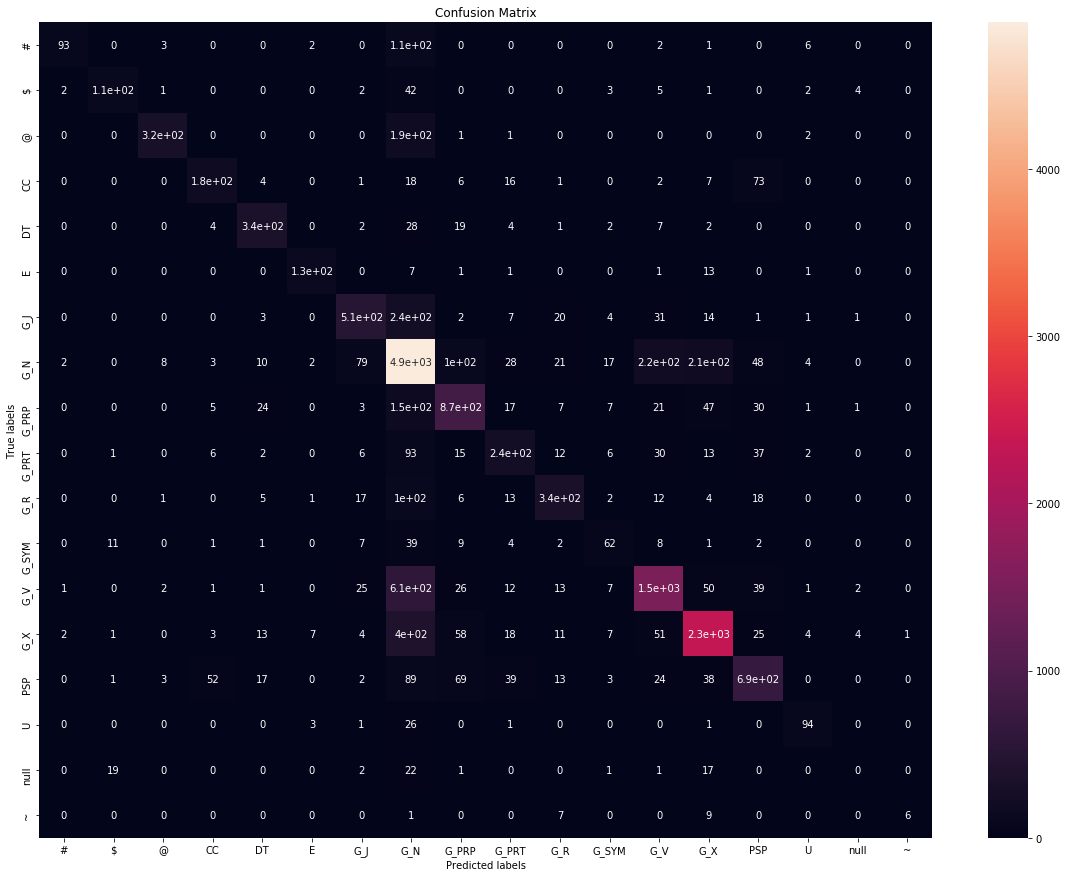

In [15]:
#visualise confution matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,15))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(tags)
ax.yaxis.set_ticklabels(tags)
plt.show()

In [16]:
#this section is for computing predicted value on test data, which will be provide later 
#please note  accuracy calculation will be done against flatten list, and not on list of list

#test_true = true_label(test_data), this function will be used only if true data list is not flatten

#test_pred = pred_label(test_data)

# Below cell will do following stesp
1. read test file one at a time
2. generate sentance list
3. predict tags list
4. open test file and append tags to each non empty line in sequence

In [17]:

test_sample = ['test_data/EN_HI_test - Copy.txt','test_data/EN_BN_test.txt','test_data/EN_TE_test.txt']


for test_doc in test_sample:
    sentance = load_data([test_doc])
    predicted_tags = pred_label(sentance)
    output_file=test_doc[0:-4]+'_AI0101.txt'
    with open(test_doc,encoding='utf-8') as doc,open(output_file,'w+',encoding='utf-8') as output:
        i = 0
        for line in doc:
            if line.strip() != '':
                output.write(line.replace('\n','\t'+predicted_tags[i]+'\n'))
                i +=1
            else:
                output.write(line)